In [26]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import atleast_2d

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
cmap = ListedColormap(sns.xkcd_palette(['denim blue', 'medium green', 'pale red']))
sns.set_style('white')
plt.rc('font', size=13)

In [27]:
iris = load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [28]:
features = iris.feature_names
data = pd.DataFrame(data=np.column_stack([iris.data, iris.target]), columns=features + ['label'])
data.label = data.label.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [29]:
data.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


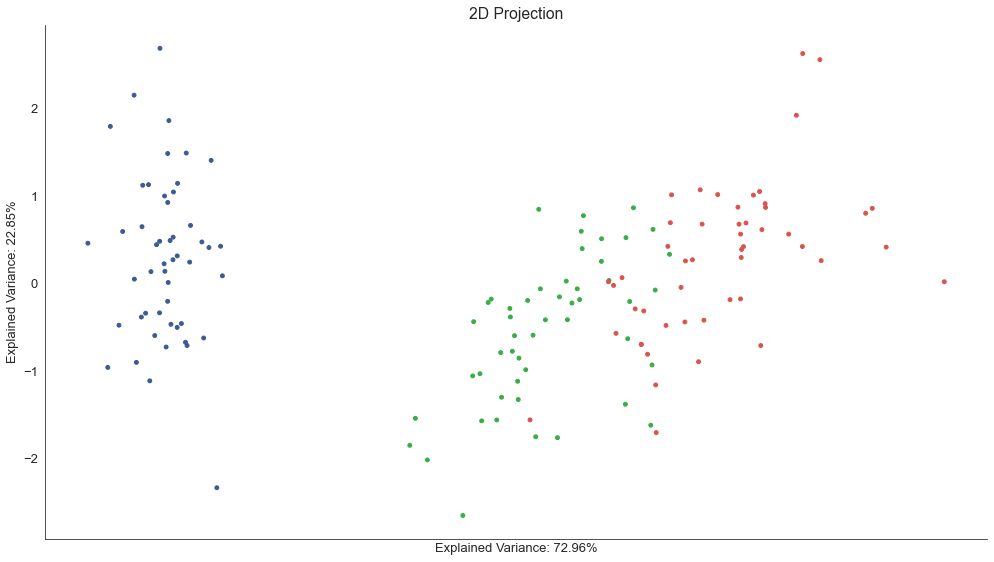

In [30]:
scaler = StandardScaler()
features_standardized = scaler.fit_transform(data[features])
n = len(data)

# Reducing Dimensionality by PCA
pca = PCA(n_components=2)
features_2D = pca.fit_transform(features_standardized)
ev1, ev2 = pca.explained_variance_ratio_
ax = plt.figure(figsize=(14, 8)).gca()
ax.set_title('2D Projection')
ax.set_xlabel(f'Explained Variance: {ev1:.2%}')
ax.set_ylabel(f'Explained Variance: {ev2:.2%}')

ax.scatter(*features_2D.T, c=data.label, s=15, cmap=cmap)
ax.set_xticklabels([])
ax.set_xticks([])
sns.despine()
plt.tight_layout();

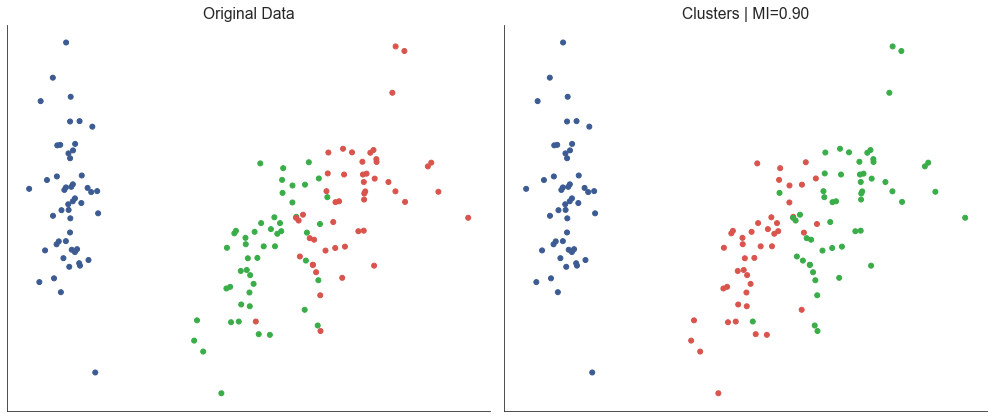

In [31]:
# Perform GMM clustering
n_components = 3
gmm = GaussianMixture(n_components=n_components)
gmm.fit(features_standardized)

data['clusters'] = gmm.predict(features_standardized)

labels, clusters = data.label, data.clusters
mi = adjusted_mutual_info_score(labels, clusters)
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

axes[0].scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
axes[0].set_title('Original Data')
axes[1].scatter(*features_2D.T, c=data.clusters, s=25, cmap=cmap)
axes[1].set_title('Clusters | MI={:.2f}'.format(mi))

for ax in axes:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

sns.despine()
fig.tight_layout()

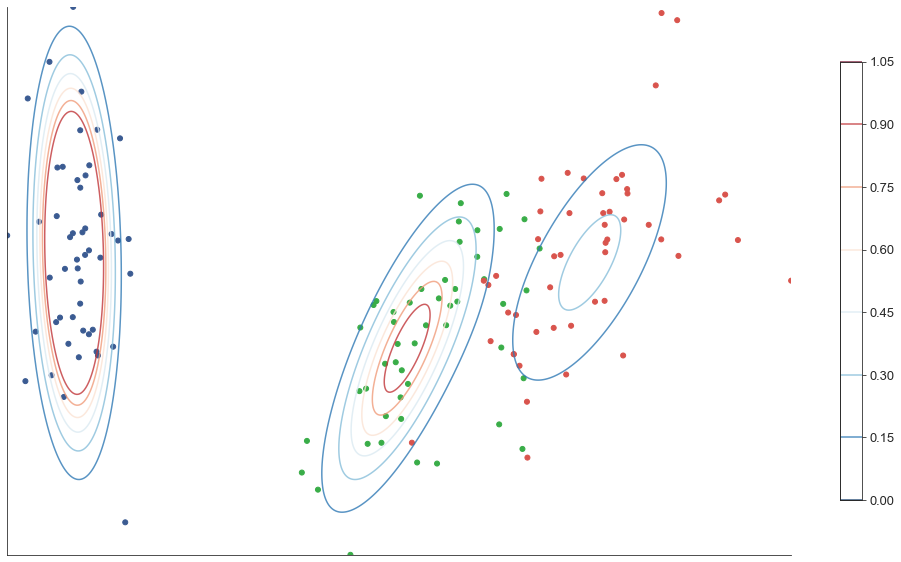

In [32]:
# Visualize Gaussian Distributions
xmin, ymin = features_2D.min(axis=0)
xmax, ymax = features_2D.max(axis=0)

x = np.linspace(xmin, xmax, 500)
y = np.linspace(ymin, ymax, 500)
X, Y = np.meshgrid(x, y)

simulated_2D = np.column_stack([np.ravel(X), np.ravel(Y)])
simulated_4D = pca.inverse_transform(simulated_2D)
# reshape to 2-dimension arrays
Z = atleast_2d(np.clip(np.exp(gmm.score_samples(simulated_4D)), a_min=0, a_max=1)).reshape(X.shape)
fig, ax = plt.subplots(figsize=(14, 8))

CS = ax.contour(X, Y, Z, cmap='RdBu_r', alpha=.8)
CB = plt.colorbar(CS, shrink=0.8)
ax.scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
sns.despine()
fig.tight_layout()

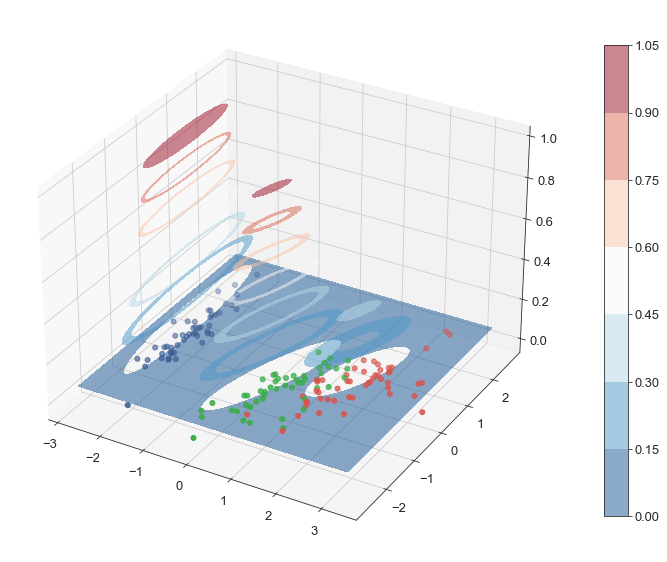

In [41]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(projection='3d')

CS = ax.contourf3D(X, Y, Z, cmap='RdBu_r', alpha=.5)
CB = plt.colorbar(CS, shrink=.86)

ax.scatter(*features_2D.T, c=data.label, s=25, cmap=cmap)
fig.tight_layout()

In [34]:
# Bayesian Information Criterion(Lower is preferred)
bic = {}
for n_components in range(2, 8):
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(features_standardized)
    bic[n_components] = gmm.bic(features_standardized)
pd.Series(bic)

2    794.709002
3    801.549163
4    853.824629
5    894.980963
6    941.863184
7    968.350804
dtype: float64